# CLAIMIFY (AVeriTec)
Members: Leonardo Cesani, Andrea Zanette, Gloria Desideri, Gianvito Caleca, Riccardo Corsiglia

AVeirTec Dataset Description:
The AVeriTec dataset consists of 4,568 real-world claims, each annotated with question-answer pairs, a veracity label, and textual justifications. The dataset is designed for automated fact-checking with evidence retrieved from the web and includes claims fact-checked by 50 different organizations. It addresses common issues such as context dependence, evidence insufficiency, and temporal leakage.

Reference: https://arxiv.org/pdf/2305.13117

This is the link to the drive folder in which there are all the relative paths: https://drive.google.com/drive/u/0/folders/1fp7hLQkcy9rpU6GxcCkySm0w0mKw-HTH

One way to run it easily it to add a link to the "NLP" folder into a "Colab Notebook" folder placed on My Drive in order to reach this configuration:
My Drive/Colab Notebook/NLP

In [1]:
!pip install --quiet country_converter
!pip install --quiet SpeechRecognition
!pip -q install -U transformers sentence-transformers
!pip -q install sentencepiece
!pip -q install accelerate

In [2]:
# base libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import country_converter as coco
import re
import plotly.graph_objects as go
import json

# sklearn utilities
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# scipy utilities
from scipy.stats import f_oneway

# speech recognition
import speech_recognition as sr

# classification libraries
import keras
from keras.utils import to_categorical
from keras import layers
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from sentence_transformers.models import Transformer, Pooling, Dense
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, LabelAccuracyEvaluator
import torch
from torch import nn
from torch import Tensor, device
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from datetime import datetime
import csv
import random
import math

# justification libraries
from sentence_transformers import InputExample, SentenceTransformer, CrossEncoder
import pickle
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
from sklearn.metrics.pairwise import paired_cosine_distances




/Users/Gloria/anaconda3/envs/claimfy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the dataset

In [3]:
with open('data/data_train.json', 'r') as file:
    dataset = json.load(file)

### Claims Dataset
From the original json dataset it is generated a new data frame. The data frame will contain the following columns:
- claim: the claim made by the speaker
- label: the label of the claim
- justification: the justification of the claim
- claim_date: the date the claim was made
- speaker: the speaker of the claim
- reporting_source: the source of the claim
- location_ISO_code: the ISO code of the location where the claim was made

In [4]:
# Build the claims' dataset
claims = [{'claim':claim['claim'], 'label': claim['label'], 'justification':claim['justification'],
           'claim_date':claim['claim_date'], 'speaker':claim['speaker'], 'reporting_source':claim['reporting_source'],
           'location_ISO_code':claim['location_ISO_code']} for claim in dataset]
claims

[{'claim': 'Hunter Biden had no experience in Ukraine or in the energy sector when he joined the board of Burisma.',
  'label': 'Supported',
  'justification': 'No former experience stated.',
  'claim_date': '25-8-2020',
  'speaker': 'Pam Bondi',
  'reporting_source': 'Speech at The Republican National Convention',
  'location_ISO_code': 'US'},
 {'claim': 'Donald Trump delivered the largest tax cuts in American history.',
  'label': 'Refuted',
  'justification': 'Three tax bills have been larger than that of Donald Trump',
  'claim_date': '25-8-2020',
  'speaker': 'Eric Trump',
  'reporting_source': 'Speech at The Republican National Convention',
  'location_ISO_code': 'US'},
 {'claim': 'In Nigeria … in terms of revenue share, 20% goes to the local government.',
  'label': 'Supported',
  'justification': 'The answer and source shows that the claim is supported as the percentage to local government is the same.',
  'claim_date': '25-8-2020',
  'speaker': 'Raila Odinga',
  'reporting_sou

In [5]:
claims_df = pd.DataFrame(claims)

In [6]:
claims_df.head()

,claim,label,justification,claim_date,speaker,reporting_source,location_ISO_code
0,Hunter Biden had no experience in Ukraine or i...,Supported,No former experience stated.,25-8-2020,Pam Bondi,Speech at The Republican National Convention,US
1,Donald Trump delivered the largest tax cuts in...,Refuted,Three tax bills have been larger than that of ...,25-8-2020,Eric Trump,Speech at The Republican National Convention,US
2,"In Nigeria … in terms of revenue share, 20% go...",Supported,The answer and source shows that the claim is ...,25-8-2020,Raila Odinga,YouTube,KE
3,Biden has pledged to stop border wall construc...,Supported,This claim should have been split into two par...,25-8-2020,Eric Trump,Speech at The Republican National Convention,US
4,"After the police shooting of Jacob Blake, Gov....",Refuted,Governor Evers did call for peace in a video s...,25-8-2020,Senator Howard Marklein,Facebook,US


In [7]:
# Convert to datetime the 'claim_date' column
claims_df['claim_date'] = pd.to_datetime(claims_df['claim_date'], format='%d-%m-%Y')

In [8]:
claims_df.to_csv('./data/postprocessed/claims.csv', index=True)

### Answers Dataset
The same operation performed on the claims json is performed on the answers one. This data frame will containù the following columns:
- answer: the answer to the question
- source_medium: the medium where the answer was found
- source_url: the url of the source
- question: the question asked
- claim_id: the id of the claim

In [9]:
answers = []
claim_id = 0
for claim in dataset:
    for question in claim['questions']:
        for answer in question['answers']:
            if answer['answer_type'] == 'Boolean':
                answers.append({'answer':answer['boolean_explanation'], 'source_medium':answer['source_medium'],
                                'source_url':answer['source_url'], 'question':question['question'],
                                'claim_id':claim_id})
            else:
                answers.append({'answer':answer['answer'], 'source_medium':answer['source_medium'],
                                'source_url':answer['source_url'], 'question':question['question'],
                                'claim_id':claim_id})
    claim_id += 1
answers

[{'answer': "Hunter bidens previous career history does not include work for energy company's.",
  'source_medium': 'Web text',
  'source_url': 'https://en.wikipedia.org/wiki/Hunter_Biden',
  'question': 'Did Hunter Biden have any experience in the energy sector at the time he joined the board of the  Burisma energy company in 2014',
  'claim_id': 0},
 {'answer': "Hunter Bidens previous career history does not include working with Ukrainian company's.",
  'source_medium': 'Web text',
  'source_url': 'https://en.wikipedia.org/wiki/Hunter_Biden',
  'question': 'Did Hunter Biden have any experience in Ukraine at the time he joined the board of the  Burisma energy company in 2014',
  'claim_id': 0},
 {'answer': 'This tax cut is the 8th largest as a percent of Gross Domestic Product (GDP) since 1918 and the 4th largest in inflation-adjusted dollars.',
  'source_medium': 'Web text',
  'source_url': 'https://www.crfb.org/blogs/president-trumps-tax-cut-largest-history-yet',
  'question': 'Did 

In [10]:
answers_df = pd.DataFrame(answers)

In [11]:
answers_df.head()

,answer,source_medium,source_url,question,claim_id
0,Hunter bidens previous career history does not...,Web text,https://en.wikipedia.org/wiki/Hunter_Biden,Did Hunter Biden have any experience in the en...,0
1,Hunter Bidens previous career history does not...,Web text,https://en.wikipedia.org/wiki/Hunter_Biden,Did Hunter Biden have any experience in Ukrain...,0
2,This tax cut is the 8th largest as a percent o...,Web text,https://www.crfb.org/blogs/president-trumps-ta...,Did the 2017 tax bill deliver the largest tax ...,1
3,Three tax bills have been larger: American Tax...,Web table,https://www.treasury.gov/resource-center/tax-p...,Has there been larger tax bills than the 2017 ...,1
4,"After months of an often fractious stalemate, ...",Web text,https://web.archive.org/web/20210307003741/htt...,Kenya’s ex-prime minister Odinga mangles his n...,2


In [12]:
answers_df.to_csv('./data/postprocessed/answers.csv', index=True)

## Load and Prepare Data

In [13]:
claims_df = pd.read_csv('./data/postprocessed/claims.csv')

In [14]:
answers_df = pd.read_csv('./data/postprocessed/answers.csv')

Some preprocessing is performed on the data frame prior to some explorative analisys. First, the speakers' names are lowercased, then `NaN`s are removed. The speaker's names are further preproceseddeleting common titles and political titles.

In [15]:
# lowercase the speaker column in the dataframe
for speaker in claims_df['speaker']:
    claims_df.loc[claims_df['speaker'] == speaker, 'speaker'] = str(speaker).lower()

In [16]:
# remove null values from the speaker column
claims_df = claims_df.dropna(subset=['speaker'])
# remove null values from the location_ISO_code column
claims_df = claims_df.dropna(subset=['location_ISO_code'])

In [17]:
def remove_titles(text):
    # Define a list of common English titles and political titles (all lowercase)
    common_titles = ['mr', 'mrs', 'ms', 'dr', 'prof', 'rev', 'capt', 'col', 'maj', 'sir', 'madam', 'miss']
    political_titles = ['president', 'vice president', 'prime minister', 'senator', 'congressman', 'congresswoman', 'governor', 'mayor']

    # Define a list of two-letter country codes (all lowercase)
    country_codes = ['us', 'uk', 'au', 'ca', 'fr', 'de', 'jp', 'cn', 'in']  # Add more as needed

    # Combine all titles and country codes into one list
    all_titles = common_titles + political_titles + country_codes

    # Construct a regular expression pattern to match titles and country codes
    pattern = r'\b(?:' + '|'.join(all_titles) + r')\b'

    text_without_titles = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return text_without_titles

claims_df['speaker'] = claims_df['speaker'].apply(remove_titles)

# remove spaces from the speaker column
claims_df['speaker'] = claims_df['speaker'].str.replace(' ', '')

# remove punctuation from the speaker column
claims_df['speaker'] = claims_df['speaker'].str.replace(r'[^\w\s]', '')

The date is converted to datetime format.

In [18]:
# transform to date time the claim_date column
claims_df['claim_date'] = pd.to_datetime(claims_df['claim_date'])

Finally, the ISO2 codes of the countries are translated to ISO3 codes due to visualziation purposes.

In [19]:
# translate iso code using country converter to ISO-3
iso2_states = np.array(claims_df['location_ISO_code'])
iso3_states = coco.convert(names=iso2_states, to='ISO3')
# add the iso3 code to the dataframe using the correct order
for i in range(len(iso3_states)):
    claims_df.loc[claims_df['location_ISO_code'] == iso2_states[i], 'location_ISO_code'] = iso3_states[i]

## Claims Analisys

In this first part some statistics are extracted. Initially, the labels, the unique speakers and the unique locazions are extracted.

In [20]:
# Collect the number of unique labels, speakers, locations
u_labels = claims_df['label'].unique()
n_labels = claims_df['label'].nunique()

u_speakers = claims_df['speaker'].unique()
n_speakers = claims_df['speaker'].nunique()

u_locations = claims_df['location_ISO_code'].unique()
n_locations = claims_df['location_ISO_code'].nunique()

print(f'Number of unique labels: {n_labels}')
print(f'Labels:\n {u_labels}')
print(f'Number of unique speakers: {n_speakers}')
print(f'Speakers:\n {u_speakers}')
print(f'Number of unique locations: {n_locations}')
print(f'Locations:\n {u_locations}')

Number of unique labels: 4
Labels:
 ['Supported' 'Refuted' 'Conflicting Evidence/Cherrypicking'
 'Not Enough Evidence']
Number of unique speakers: 1179
Speakers:
 ['pambondi' 'erictrump' 'railaodinga' ... 'donitabooher' 'yusharahman'
 'sunilbassi']
Number of unique locations: 53
Locations:
 ['USA' 'KEN' 'IND' 'NGA' 'NZL' 'GHA' 'ZAF' 'HKG' 'GBR' 'PHL' 'KOR' 'CAN'
 'SWE' 'RUS' 'TUR' 'PAK' 'AUS' 'TWN' 'MMR' 'DEU' 'IRL' 'IRN' 'ESP' 'CHE'
 'CHN' 'TZA' 'MEX' 'UGA' 'ISR' 'PRK' 'ITA' 'SAU' 'ARE' 'MDG' 'SRB' 'LKA'
 'MYS' 'JPN' 'VAT' 'THA' 'ETH' 'ZWE' 'SYR' 'BWA' 'UKR' 'IDN' 'SWZ' 'FRA'
 'POL' 'MOZ' 'MWI' 'EGY' 'BRB']


The dataset of refuted claims is extracted.

In [21]:
# detect the countries with the most refuted, conflicting and not evident claims
refuted_df = claims_df[(claims_df['label'] == 'Refuted') | (claims_df['label'] == 'Conflicting Evidence/Cherrypicking')]

### Claims by State

In this section some statistics and plots are estracted from the refuted dataset. In particular, the number of claims by state is conisidered.

In [22]:
# group by location_ISO_code and count the number of refuted claims
refuted_by_state = refuted_df.groupby('location_ISO_code').size().reset_index(name='count')
refuted_by_state

,location_ISO_code,count
0,ARE,1
1,AUS,24
2,BRB,1
3,BWA,1
4,CAN,7
5,CHE,1
6,CHN,19
7,DEU,2
8,EGY,1
9,ESP,2


In [23]:
# get the overall claims by state
claims_by_state =  claims_df.groupby('location_ISO_code').size().reset_index(name='count')
claims_by_state

,location_ISO_code,count
0,ARE,2
1,AUS,30
2,BRB,1
3,BWA,1
4,CAN,8
5,CHE,2
6,CHN,29
7,DEU,3
8,EGY,1
9,ESP,2


In [24]:
# get the percentage of refuted claims by state matching by location_ISO_code
refuted_by_state = refuted_by_state.merge(claims_by_state, on='location_ISO_code')
refuted_by_state['percentage'] = refuted_by_state['count_x'] / refuted_by_state['count_y']
refuted_by_state

,location_ISO_code,count_x,count_y,percentage
0,ARE,1,2,0.500000
1,AUS,24,30,0.800000
2,BRB,1,1,1.000000
3,BWA,1,1,1.000000
4,CAN,7,8,0.875000
5,CHE,1,2,0.500000
6,CHN,19,29,0.655172
7,DEU,2,3,0.666667
8,EGY,1,1,1.000000
9,ESP,2,2,1.000000


In [25]:
# rename the columns
refuted_by_state = refuted_by_state.rename(columns={'count_x': 'refuted', 'count_y': 'total'})

In [26]:
# sort the states by percentage of refuted claims
refuted_by_state = refuted_by_state.sort_values(by='percentage', ascending=False)
refuted_by_state

,location_ISO_code,refuted,total,percentage
24,MDG,1,1,1.000000
29,MYS,1,1,1.000000
40,TUR,2,2,1.000000
43,UGA,1,1,1.000000
25,MEX,3,3,1.000000
26,MMR,1,1,1.000000
27,MOZ,1,1,1.000000
28,MWI,1,1,1.000000
42,TZA,1,1,1.000000
44,UKR,3,3,1.000000


In order to have meaningfull statistics, only the countires with a reasonable number of claims are retrieved.

In [27]:
# filter the states with more than 5 claims
refuted_by_state = refuted_by_state[refuted_by_state['total'] > 5]
refuted_by_state

,location_ISO_code,refuted,total,percentage
31,NZL,7,7,1.000000
33,PHL,32,34,0.941176
23,LKA,10,11,0.909091
4,CAN,7,8,0.875000
1,AUS,24,30,0.800000
16,IND,192,263,0.730038
14,HKG,4,6,0.666667
45,USA,673,1025,0.656585
6,CHN,19,29,0.655172
17,IRL,7,11,0.636364


In the plot, it is possible to visualize the countries with the highest number of refuted claims.

In [28]:
# build a map with the percentage of refuted claims by state
fig = px.choropleth(refuted_by_state, locations='location_ISO_code', locationmode='ISO-3', color='percentage', hover_name='location_ISO_code', color_continuous_scale='Viridis', title='Percentage of refuted claims by state')
fig.show()

We can see Canada ha is percentage more refuted claims. However from the table above Canada has only 8 total claims. Let's see the countries with more refuted claims.

In [29]:
fig = px.choropleth(refuted_by_state, locations='location_ISO_code', locationmode='ISO-3', color='refuted', hover_name='location_ISO_code', color_continuous_scale='Viridis', title='Total count of refuted claims by state')
fig.show()

In this chart USA and India are the ones with higest count of refuted claims.

### Claims by Speaker

In this section, the very same operation peformed on the countries is done on the speaker column of the dataframe.

In [30]:
# detect the speakers with the most refuted claims
refuted_by_speaker = refuted_df.groupby('speaker').size().reset_index(name='count')
refuted_by_speaker

,speaker,count
0,.ayodolaadigun,1
1,.deborahbirx,1
2,.jeonkwang-hun,1
3,.juliusokojie,1
4,.mattmccarthy,1
...,...,...
867,प्रशान्तिन्यूज़पेपर,1
868,අපිහෙළයෝ,1
869,රොබින්හුඩ්-robinhood,1
870,හොරොව්පතානපාරම්පරිකහෙළවෙදගෙදර,1


In [31]:
# get the overall claims by speaker
claims_by_speaker =  claims_df.groupby('speaker').size().reset_index(name='count')
claims_by_speaker

,speaker,count
0,,1
1,.ayodolaadigun,1
2,.deborahbirx,1
3,.isaibrahim-ministerofcommunicationsanddigital...,1
4,.jeonkwang-hun,1
...,...,...
1174,प्रशान्तिन्यूज़पेपर,1
1175,අපිහෙළයෝ,1
1176,රොබින්හුඩ්-robinhood,1
1177,හොරොව්පතානපාරම්පරිකහෙළවෙදගෙදර,1


In [32]:
refuted_by_speaker['speaker'] = refuted_by_speaker['speaker'].str.replace('.', '')
refuted_by_speaker.head()

,speaker,count
0,ayodolaadigun,1
1,deborahbirx,1
2,jeonkwang-hun,1
3,juliusokojie,1
4,mattmccarthy,1


In [33]:
claims_by_speaker['speaker'] = claims_by_speaker['speaker'].str.replace('.', '')
claims_by_speaker

,speaker,count
0,,1
1,ayodolaadigun,1
2,deborahbirx,1
3,isaibrahim-ministerofcommunicationsanddigitale...,1
4,jeonkwang-hun,1
...,...,...
1174,प्रशान्तिन्यूज़पेपर,1
1175,අපිහෙළයෝ,1
1176,රොබින්හුඩ්-robinhood,1
1177,හොරොව්පතානපාරම්පරිකහෙළවෙදගෙදර,1


In [34]:
# get the percentage of refuted claims by speaker matching by speaker
refuted_by_speaker = refuted_by_speaker.merge(claims_by_speaker, on='speaker')
refuted_by_speaker['percentage'] = refuted_by_speaker['count_x'] / refuted_by_speaker['count_y']
refuted_by_speaker

,speaker,count_x,count_y,percentage
0,ayodolaadigun,1,1,1.0
1,deborahbirx,1,1,1.0
2,jeonkwang-hun,1,1,1.0
3,juliusokojie,1,2,0.5
4,mattmccarthy,1,1,1.0
...,...,...,...,...
867,प्रशान्तिन्यूज़पेपर,1,1,1.0
868,අපිහෙළයෝ,1,1,1.0
869,රොබින්හුඩ්-robinhood,1,1,1.0
870,හොරොව්පතානපාරම්පරිකහෙළවෙදගෙදර,1,1,1.0


In [35]:
# rename the columns
refuted_by_speaker = refuted_by_speaker.rename(columns={'count_x': 'refuted', 'count_y': 'total'})

In [36]:
# sort the speakers by percentage of refuted claims
refuted_by_speaker = refuted_by_speaker.sort_values(by='percentage', ascending=False)
refuted_by_speaker

,speaker,refuted,total,percentage
0,ayodolaadigun,1,1,1.000000
569,nellynelyzo,1,1,1.000000
556,nancypelos,1,1,1.000000
557,nancypelosi,2,2,1.000000
558,nangibaba,1,1,1.000000
...,...,...,...,...
336,henryrotich,2,15,0.133333
148,bjpgovernment,1,11,0.090909
90,amyklobuchar,1,12,0.083333
543,muhammadubuhari,1,12,0.083333


Again, only the speakers with a reasobable number of claims is retireved.

In [37]:
# filter the speakers with more than 10 claims
refuted_by_speaker = refuted_by_speaker[refuted_by_speaker['total'] > 10]
refuted_by_speaker

,speaker,refuted,total,percentage
717,socialmediausers,10,13,0.769231
254,donaldtrump,177,243,0.728395
848,williamruto,15,28,0.535714
718,socratesmbamalu,13,26,0.500000
444,kyledarbyshire,8,16,0.500000
81,aljazeera,5,11,0.454545
390,joebiden,17,38,0.447368
137,berniesanders,13,32,0.406250
269,elizabethwarren,5,13,0.384615
856,wycliffeoparanya,16,46,0.347826


In [38]:
# build a bar plot with the percentage of refuted claims by speaker
fig = px.bar(refuted_by_speaker, x='speaker', y='percentage', title='Percentage of refuted claims by speaker', labels={'speaker': 'Speaker', 'percentage': 'Percentage of refuted claims'})
fig.show()

From only the percentage of refuted claims it looks like social media users is the most unreliable category. We provided also a chart of the total number of refuted claims below from which Donald Trump appears as the most unreliable source of informations

In [39]:
fig = px.bar(refuted_by_speaker, x='speaker', y='total', title='Total refuted claims by speaker', labels={'speaker': 'Speaker', 'percentage': 'Percentage of refuted claims'})
fig.show()

### Claims by Date

The same operations that have been done before are performed by date of the claim.

In [40]:
# Index with the date
refuted_df.index = pd.to_datetime(refuted_df['claim_date'].values)

# resample the dataset
claims_by_date = refuted_df.resample('M').size().reset_index(name='count')

#rename the columns
claims_by_date = claims_by_date.rename(columns={'index': 'claim_date'})
claims_by_date

/var/folders/33/rzdkhzl567j2mkrbw3cn1w080000gn/T/ipykernel_69597/3781033649.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,claim_date,count
0,1920-06-30,1
1,1920-07-31,0
2,1920-08-31,0
3,1920-09-30,0
4,1920-10-31,0
...,...,...
1198,2020-04-30,93
1199,2020-05-31,60
1200,2020-06-30,118
1201,2020-07-31,111


In [41]:
# filter out dates less than 2019-01-01
claims_by_date = claims_by_date[claims_by_date['claim_date'] > '2017-01-01']

In [42]:
# plot the time series of claims by date
fig = px.line(claims_by_date, x='claim_date', y='count', title='Number of claims by date', labels={'claim_date': 'Date', 'count': 'Number of claims'})
fig.show()

Finally, some plot are produced to show the relaiton between the date and state with the number of claims and date and speaker with the number of claims.

In [43]:
# group by date and location_ISO_code
claims_by_date_location = refuted_df.groupby([pd.Grouper(freq='M'), 'location_ISO_code']).size().reset_index(name='count')
# rename the columns
claims_by_date_location = claims_by_date_location.rename(columns={'level_0': 'claim_date'})
claims_by_date_location

/var/folders/33/rzdkhzl567j2mkrbw3cn1w080000gn/T/ipykernel_69597/53733591.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,claim_date,location_ISO_code,count
0,1920-06-30,IND,1
1,1921-03-31,USA,1
2,1922-08-31,KEN,1
3,2012-01-31,IND,1
4,2014-01-31,GBR,1
...,...,...,...
270,2020-08-31,RUS,1
271,2020-08-31,TUR,1
272,2020-08-31,TWN,1
273,2020-08-31,USA,43


In [44]:
# get the 6 states with the most claims from refuted_by_state
top_states = refuted_by_state.head(10)
# filter the claims by date and location_ISO_code by the top states
claims_by_date_location = claims_by_date_location[claims_by_date_location['location_ISO_code'].isin(top_states['location_ISO_code'])]
claims_by_date_location

,claim_date,location_ISO_code,count
0,1920-06-30,IND,1
1,1921-03-31,USA,1
3,2012-01-31,IND,1
8,2015-04-30,USA,2
9,2015-05-31,USA,1
...,...,...,...
262,2020-08-31,HKG,1
263,2020-08-31,IND,8
267,2020-08-31,NZL,3
269,2020-08-31,PHL,6


In [45]:
# filter out dates less than 2019-01-01
claims_by_date_location = claims_by_date_location[claims_by_date_location['claim_date'] > '2017-01-01']
# rename the location_ISO_code to location
claims_by_date_location = claims_by_date_location.rename(columns={'location_ISO_code': 'location'})

In [46]:
# plot the time series of claims by date and location_ISO_code
fig = px.line(claims_by_date_location, x='claim_date', y='count', color='location', title='Number of claims by date and location', labels={'claim_date': 'Date', 'count': 'Number of claims'})
fig.show()

In [47]:
# group by date and speaker
claims_by_date_speaker = refuted_df.groupby([pd.Grouper(freq='M'), 'speaker']).size().reset_index(name='count')
# rename the columns
claims_by_date_speaker = claims_by_date_speaker.rename(columns={'level_0': 'claim_date'})
claims_by_date_speaker

/var/folders/33/rzdkhzl567j2mkrbw3cn1w080000gn/T/ipykernel_69597/2145814214.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,claim_date,speaker,count
0,1920-06-30,ani,1
1,1921-03-31,@alwakeelnews,1
2,1922-08-31,davidmaraga,1
3,2012-01-31,viralsocialmediapost,1
4,2014-01-31,diannaagron,1
...,...,...,...
958,2020-08-31,virendraprajapati,1
959,2020-08-31,vladimirputin,1
960,2020-08-31,williamgheen,1
961,2020-08-31,zwelikkhize,1


In [48]:
# get the 10 speakers with the most claims from refuted_by_speaker
top_speakers = refuted_by_speaker.head(10)
# filter the claims by date and speaker by the top speakers
claims_by_date_speaker = claims_by_date_speaker[claims_by_date_speaker['speaker'].isin(top_speakers['speaker'])]
claims_by_date_speaker

,claim_date,speaker,count
9,2015-04-30,donaldtrump,1
11,2015-10-31,donaldtrump,1
62,2018-11-30,donaldtrump,1
71,2018-12-31,donaldtrump,1
76,2019-01-31,donaldtrump,1
87,2019-02-28,berniesanders,2
92,2019-02-28,donaldtrump,29
116,2019-02-28,williamruto,11
120,2019-03-31,berniesanders,1
130,2019-03-31,donaldtrump,22


In [49]:
# filter out dates less than 2019-01-01
claims_by_date_speaker = claims_by_date_speaker[claims_by_date_speaker['claim_date'] > '2017-01-01']

In [50]:
# plot the time series of claims by date and speaker
fig = px.line(claims_by_date_speaker, x='claim_date', y='count', color='speaker', title='Number of claims by date and speaker', labels={'claim_date': 'Date', 'count': 'Number of claims'})
fig.show()

## Cluster Analysis

In this section a cluster analysis is performed. The aim of this analisis is to detect some recurrent topics in the dataset.

### Prepare Data For Cluster Analysis

In [51]:
# import data
claims_df = pd.read_csv('data/postprocessed/claims.csv')

In [52]:
# delete nans in the claims and answer column
claims_df = claims_df.dropna(subset=['claim'])

In [53]:
# build a vector for the claims
claims_str = np.array(claims_df['claim'])
claims_str

array(['Hunter Biden had no experience in Ukraine or in the energy sector when he joined the board of Burisma.',
       'Donald Trump delivered the largest tax cuts in American history.',
       'In Nigeria … in terms of revenue share, 20% goes to the local government.',
       ...,
       'Matt Hancock owns the company responsible for supplying the NHS.',
       '£1 billion was given to 13 companies for PPE but no PPE has been supplied.',
       'Mixing one tablespoon of 2% iodine and one cup of baby oil will create a substance that removes body hair.'],
      dtype=object)

In [54]:
# split in train and test
claims_train, claims_test = train_test_split(claims_str, test_size=0.2, random_state=42)
print(f'Train size: {len(claims_train)}')
print(f'Test size: {len(claims_test)}')

Train size: 2453
Test size: 614


In [55]:
# define a vectorizer
vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)

In [56]:
# fit the vectorizer
vector_claims_train = vectorizer.fit_transform(claims_train)

In [57]:
# get the vocabulary
vocab = vectorizer.get_feature_names_out()
len(vocab)

1141

# LDA - Latent Dirichlet Allocation

The cluster analysis is done using LDA. In order to find the proper number of topics, a perplexity analysis is carried out.

In [58]:
# perplexity analysis using bagging method
def perplexity_analysis(n_topics: list, data: np.array) -> list:
    perplexity = []
    for n in n_topics:
      claims_train_LDA, claims_test_LDA = train_test_split(data, test_size=0.2, random_state=42)
      vector_train_LDA = vectorizer.fit_transform(claims_train_LDA)
      lda = LatentDirichletAllocation(n_components=n, learning_method='online', random_state=42, max_iter=15, n_jobs=5)
      lda.fit_transform(vector_train_LDA)
      vector_test_LDA = vectorizer.fit_transform(claims_test_LDA)
      p = lda.perplexity(vector_test_LDA)
      perplexity.append(p)

      print(f'Perplexity for {n} topics: {p}')

    # plot the results of the perplexity analysis
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(n_topics, perplexity, 'o-', color='blue', label='Perplexity')
    plt.grid(True)
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity')
    plt.xticks(n_topics)
    plt.legend()
    plt.title('LDA')

    return perplexity

Perplexity for 1 topics: 2620.9502206236643
Perplexity for 2 topics: 5008.09434665361
Perplexity for 3 topics: 8243.010986513887
Perplexity for 4 topics: 11487.818025866824
Perplexity for 5 topics: 14368.430847524614
Perplexity for 6 topics: 18661.019730016753
Perplexity for 7 topics: 21441.877332020715
Perplexity for 8 topics: 24019.73901323461
Perplexity for 9 topics: 26913.48428786859


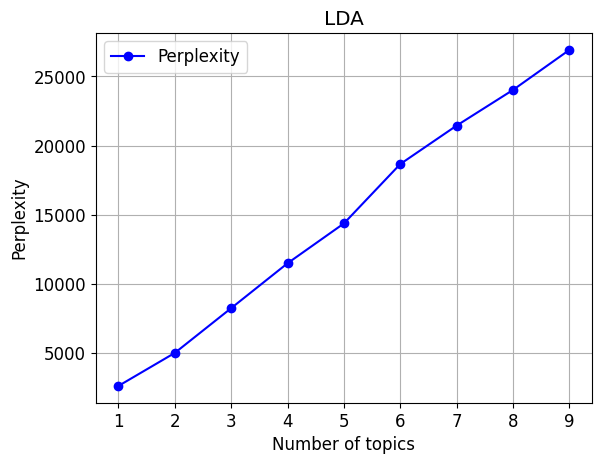

In [59]:
perplexity = perplexity_analysis(np.arange(1, 10), claims_str)

It is possible to note that the perplexity analysis that there is no eilbow nor knee, then it is not possible to be sure about the number of clusters. in order to be conservative, we try to perform a complete LDA using 4 as number of topics. Anyway, it is very likely that the dataset has no proper distinction between topics.

In [60]:
# retrain the model with the 3 as numer of topics
lda = LatentDirichletAllocation(n_components=4, learning_method='online', random_state=42, max_iter=15, n_jobs=5)
lda.fit_transform(vector_claims_train)

array([[0.04309485, 0.88260589, 0.03807979, 0.03621947],
       [0.02510699, 0.0274652 , 0.02521401, 0.9222138 ],
       [0.02103656, 0.02130532, 0.02178847, 0.93586965],
       ...,
       [0.20440666, 0.71221953, 0.04166889, 0.04170492],
       [0.75921826, 0.17701067, 0.03193533, 0.03183574],
       [0.56377612, 0.18926924, 0.20991152, 0.03704313]])

In [61]:
# print the topics
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

"""
Topic 1: Political Statements & Events
Topic 2: Global Health Crisis
Topic 3: African Pandemic Impact
Topic 4: US Presidential Politics
"""

Topic 1:	 [president, water, years, obama, said, 2020, people, government, coronavirus, march]
Topic 2:	 [19, covid, 000, nigeria, people, million, kenya, new, years, 2019]
Topic 3:	 [south, free, africa, year, million, number, children, coronavirus, died, said]
Topic 4:	 [trump, president, donald, coronavirus, states, world, biden, united, people, said]


'\nTopic 1: Political Statements & Events\nTopic 2: Global Health Crisis\nTopic 3: African Pandemic Impact\nTopic 4: US Presidential Politics\n'

From the keywords of each topic it appears even more clearly that LDA can't find a clear topic structure

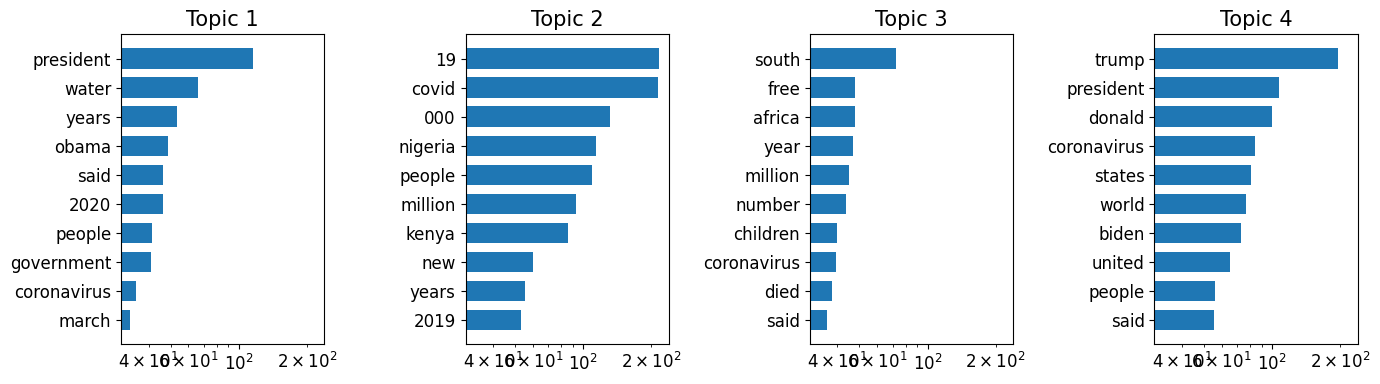

In [62]:
# plot the clusters num_words = 10
num_words = 10
cols = 4
rows = int(len(lda.components_)/4)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

## t-SNE

In [63]:
# plot with t-stne
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_claims_train))
tsne_embedding.shape

(2453, 3)

In [64]:
[x, y, z] = np.transpose(tsne_embedding)
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_claims_train)]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=freq_topic,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

By applying t-SNE the cluster seem close to each other

In [65]:
# get the labels for the whole claims dataset
vectorizer_complete = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_claims = vectorizer_complete.fit_transform(claims_str)
labels_lda = lda.fit_transform(vector_claims)
labels_lda.shape

(3067, 4)

In [66]:
# get the argmax label for each claim
labels_lda = np.argmax(labels_lda, axis=1)


Now we apply t-SNE on the whole dataset of vectorized claims

In [67]:
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_claims))
tsne_embedding.shape
[x, y, z] = np.transpose(tsne_embedding)
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_claims)]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=freq_topic,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

## ANOVA

An ANOVA analysis is performed on the dataset of the frequencies of the classes' labels with respect to the topics' membership.

In [ ]:
# encode the labels in claims_df
le = LabelEncoder()
labels = le.fit_transform(claims_df['label'])

In [ ]:
# build the frequences dataset (no anova with categorical variables)
frequencies = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        frequencies[i, j] = np.sum((labels_lda == i) & (labels == j))
# rename the columns with the topics, the rows with the labels
frequencies_df = pd.DataFrame(frequencies, columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'], index=le.classes_)
print(frequencies_df)

# transpose the array for the anova
frequencies = frequencies.T

                                    Topic 1  Topic 2  Topic 3  Topic 4
Conflicting Evidence/Cherrypicking     43.0     77.0    331.0    257.0
Not Enough Evidence                    45.0     58.0    442.0    150.0
Refuted                                63.0     80.0    560.0    218.0
Supported                              44.0     67.0    409.0    223.0


In [ ]:
# perform the anova
# H0: the means of the two groups are equal
# H1: the means of the two groups are different
f, p = f_oneway(frequencies[0], frequencies[1], frequencies[2], frequencies[3], np.array([0, 1, 2, 3]))

In [ ]:
print(f'F-value: {f}, p-value: {p}')

F-value: 55.03965827404705, p-value: 8.704392503382681e-09


Being the p-value close to zero the H0 is rejected, and it is possible to say that the label assigned by the clustering have an influence over the distribution of the labels in the dataset.

# Claim-Answer Matching and Classification

In this part of the project, we implemented a solution inspired by the methodology presented in a research paper (https://arxiv.org/pdf/2010.09926) that uses Sentence-BERT (SBERT) to match claims to the most k relevant answers.

Following this, we build a classifier to classify each claim-answer pair, using majority voting to determine the final classification.

![Architecture](https://drive.google.com/uc?export=view&id=1zfik07QoarXyTdYOtsJAQdukzUTlU46_)

## Import and preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
claims_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/NLP/postprocessed/claims.csv',
    index_col = 0,
    usecols = ['Unnamed: 0', 'claim', 'label', 'justification'],
    dtype = {'claim': str, 'label': str, 'justification':str}
)
answers_df = pd.read_csv(
    './drive/MyDrive/Colab Notebooks/NLP/postprocessed/answers.csv',
    index_col = 0,
    usecols = ['Unnamed: 0', 'answer', 'question', 'claim_id'],
    dtype = {'answer': str, 'question': str, 'claim_id':int}
)

In [ ]:
claims_df['claim_id'] = claims_df.index

In [ ]:
# Remove \n from claims, answers and questions
claims_df['claim'] = claims_df['claim'].apply(lambda x: x.replace('\n', ''))
answers_df['answer'] = answers_df['answer'].apply(lambda x: x.replace('\n', ''))
answers_df['question'] = answers_df['question'].apply(lambda x: x.replace('\n', ''))
# Remove . and add ? at the end of each question
answers_df['question'] = answers_df['question'].str.replace('\.$', '')
answers_df['question'] = answers_df['question'] + '?'

In [ ]:
# Split claims into train (90%) and test set (10%)
test_size = .1
claims_df['split'] = np.random.choice(['train', 'test'], size=len(claims_df), p=[1-test_size, test_size])

In [ ]:
np.unique(claims_df['label'], return_counts=True) # 6.3 9.1 56.7 27.6

(array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
        'Refuted', 'Supported'], dtype=object),
 array([ 195,  282, 1742,  848]))

In [ ]:
np.unique(claims_df[claims_df['split']=='test']['label'], return_counts=True) # 6.8 7.4 59.7 25.9

(array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
        'Refuted', 'Supported'], dtype=object),
 array([ 21,  23, 184,  80]))

## SBERT

SBERT is a modification of the pre-trained BERT network that provides semantically meaningful sentence embeddings. These embeddings are particularly useful for tasks involving semantic textual similarity.

To effectively train the SBERT model, it is crucial to create both positive and negative samples:


*   Positive Samples: Pairs of claims and relevant (correct) question-answers.
*   Negative Samples: Pairs of claims and irrelevant (incorrect) question-answers.

To enhance the relevance of the matched answers, we aim to minimize the cosine distance (maximize the cosine similarity) between the embeddings of claims and their corresponding correct answers. By doing this, we ensure that the embeddings of semantically related claim-answer pairs are closer in the vector space.

![Architecture](https://drive.google.com/uc?export=view&id=1H8bu1Joo5q0Jc5p9JxlymXCIY3AjpD-O)



In [ ]:
# Create samples for training and testing purposes
samples_train = []
samples_test = []

for index, claim in claims_df.iterrows():
    answers = answers_df[answers_df["claim_id"]==index] # Find all related answers to that claim
    negative_idxs = list(set(range(len(answers_df))) - set(answers.index)) # Ids of all the other irrelevant answers
    if claim['split'] == 'train':
        for _, answer in answers.iterrows():
            # Create positive examples
            samples_train.append(InputExample(texts=[claim["claim"], answer["question"]+" "+answer['answer']], label=1.))
            # Sample random answers
            neg_idx = random.choice(negative_idxs)
            samples_train.append(InputExample(texts=[claim["claim"], answers_df.iloc[neg_idx]["question"]+" "+answers_df.iloc[neg_idx]["answer"]], label=-1.))
    else:
        for _, answer in answers.iterrows():
            samples_test.append(InputExample(texts=[claim["claim"], answer["question"]+" "+answer['answer']], label=1.))
            neg_idx = random.choice(negative_idxs)
            samples_test.append(InputExample(texts=[claim["claim"], answers_df.iloc[neg_idx]["question"]+" "+answers_df.iloc[neg_idx]["answer"]], label=-1.))


In [ ]:
len(samples_train), len(samples_test)

(15326, 1626)

### Train model

The nli-distilroberta-base-v2 is a pre-trained model from the Sentence Transformers library designed for Natural Language Inference (NLI) tasks. It is a distilled version of the roberta-base model, fine-tuned specifically for tasks that involve understanding the relationship between pairs of sentences.

In [ ]:
model_name = "nli-distilroberta-base-v2"
train_batch_size = 16
num_epochs = 4
model_save_path = (
    "./drive/MyDrive/Colab Notebooks/NLP/models/" + model_name + "-claim-question-answer"
)

In [ ]:
model_s = SentenceTransformer(model_name)

In [ ]:
train_dataloader = DataLoader(samples_train, shuffle=True, batch_size=train_batch_size) # Instantiate a torch dataloader
train_loss = losses.CosineSimilarityLoss(model=model_s) # We want to minimise the cosine distance between related claim-answers
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up

In [ ]:
model_s.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/958 [00:00<?, ?it/s]

Iteration:   0%|          | 0/958 [00:00<?, ?it/s]

Iteration:   0%|          | 0/958 [00:00<?, ?it/s]

Iteration:   0%|          | 0/958 [00:00<?, ?it/s]

### Test model

In [ ]:
model_s = SentenceTransformer("./drive/MyDrive/Colab Notebooks/NLP/models/" + model_name + "-claim-question-answer")

In [ ]:
# Evaluate the model on unseen claims
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(samples_test, name="sts-test")
test_evaluator(model_s)

0.7908389690936929

### Save embeddings

To facilitate efficient testing and evaluation of the ensemble model with the classifier, we precomputed and saved the embeddings for all claims and answers in the dataset. This approach ensures that during the testing phase, we can directly use these embeddings without recomputing them, saving both time and computational resources

In [ ]:
# Concatenate question and answer!!!
answers_df['concatenate']= answers_df['question']+ ' '+ answers_df['answer']
encoded_q_a = model_s.encode(answers_df['concatenate'].to_numpy(), convert_to_numpy=True)
np.save("./drive/MyDrive/Colab Notebooks/NLP/encoded_q_a_test10.npy", encoded_q_a, allow_pickle=True)

In [ ]:
encoded_claims = model_s.encode(claims_df['claim'].to_numpy(), convert_to_numpy=True)
np.save("./drive/MyDrive/Colab Notebooks/NLP/encoded_claims_test10.npy", encoded_claims, allow_pickle=True)

In [ ]:
encoded_claims.shape, encoded_q_a.shape

((3067, 768), (8476, 768))

In [ ]:
# A quick test

query_embedding = np.repeat([model_s.encode("The Kenyan judiciary does not even get 1% of the national budget.", convert_to_numpy=True)], len(encoded_q_a), axis=0)
# Calculate paired cosine distances
cosine_distances = paired_cosine_distances(query_embedding, encoded_q_a)
# Find indexes of most similar embeddings
most_similar_indexes = np.argsort(cosine_distances)

for i in most_similar_indexes[:3]:
    print(answers_df.iloc[i]['answer'])

Maraga, who assumed office in 2016, asked for more funding as the judiciary does not even get 1% of the national budget. For the judiciary to operate properly  they should get at least 2.5% of the national budget. This claim is correct.
the judiciary started recieving less than 1% since 2015 but did not complain till 2019
Budget speeches for 2020/21 show the judiciary received 0.6% of the national budget.


## Baseline classifier

Once we had the SBERT-based embeddings ready, we defined a baseline score using a Bidirectional LSTM (Long Short-Term Memory) model implemented with TensorFlow and Keras. This model aimed to leverage the sequential nature of the embeddings for improved classification performance.



In [ ]:
embedded_claims = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_claims_test10.npy", allow_pickle=True)
embedded_q_a = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_q_a_test10.npy", allow_pickle=True)

In [ ]:
labels = claims_df['label']
class_names = np.unique(labels)
class_names

array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
       'Refuted', 'Supported'], dtype=object)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
# Transform labels
y_encoded = label_encoder.fit_transform(labels)
# Convert integer labels to one-hot encoded format
y_ohe = to_categorical(y_encoded)

In [ ]:
X_temp = []
X_test = []
y_test = []
y_temp = []

for idx_c, claim in claims_df.iterrows():
    answers = answers_df[answers_df["claim_id"]==idx_c]
    if claim['split'] == 'train':
        for idx_a, _ in answers.iterrows():
            X_temp.append([embedded_claims[idx_c], embedded_q_a[idx_a]])
            y_temp.append(y_ohe[idx_c])
    else:
        for idx_a, _ in answers.iterrows():
            X_test.append([embedded_claims[idx_c], embedded_q_a[idx_a]])
            y_test.append(y_ohe[idx_c])

X_temp = np.array(X_temp, dtype=np.float64)
y_temp = np.array(y_temp)
X_test = np.array(X_test, dtype=np.float64)
y_test = np.array(y_test)

print(X_temp.shape, y_temp.shape)

(7663, 2, 768) (7663, 4)


In [ ]:
# Split the temp set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, shuffle=True, stratify=y_temp)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape,  y_val.shape, y_test.shape

((6896, 2, 768), (767, 2, 768), (813, 2, 768), (6896, 4), (767, 4), (813, 4))

In [ ]:
input_shape = X_train.shape[1:]
sequences_input = keras.Input(shape=input_shape, dtype="float64")

# Reshape the input to be compatible with LSTM layers (3D input)
reshaped_input = layers.Reshape((input_shape[0], input_shape[1]))(sequences_input)

# Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(16))(reshaped_input)
x = layers.Dropout(0.5)(x)
# Dense layers
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)

# Output layer
preds = layers.Dense(len(class_names), activation="softmax")(x)

# Create the model
classifier = keras.Model(sequences_input, preds)
classifier.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 2, 768)]          0         
                                                                 
 reshape_22 (Reshape)        (None, 2, 768)            0         
                                                                 
 bidirectional_20 (Bidirect  (None, 32)                100480    
 ional)                                                          
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_70 (Dense)            (None, 256)               8448      
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                          

### Train model

In [ ]:
optimizer = Adam()

# Compile the model
classifier.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
history = classifier.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         batch_size=64)

Epoch 1/50
108/108 [==============================] - 44s 14ms/step - loss: 1.1112 - accuracy: 0.5619 - val_loss: 1.0466 - val_accuracy: 0.5932
Epoch 2/50
108/108 [==============================] - 1s 7ms/step - loss: 1.0477 - accuracy: 0.5916 - val_loss: 1.0196 - val_accuracy: 0.6063
Epoch 3/50
108/108 [==============================] - 1s 7ms/step - loss: 1.0282 - accuracy: 0.6032 - val_loss: 0.9924 - val_accuracy: 0.6115
Epoch 4/50
108/108 [==============================] - 1s 7ms/step - loss: 1.0013 - accuracy: 0.6182 - val_loss: 0.9706 - val_accuracy: 0.6193
Epoch 5/50
108/108 [==============================] - 1s 7ms/step - loss: 0.9809 - accuracy: 0.6209 - val_loss: 0.9471 - val_accuracy: 0.6349
Epoch 6/50
108/108 [==============================] - 1s 7ms/step - loss: 0.9588 - accuracy: 0.6257 - val_loss: 0.9291 - val_accuracy: 0.6467
Epoch 7/50
108/108 [==============================] - 1s 7ms/step - loss: 0.9334 - accuracy: 0.6346 - val_loss: 0.8813 - val_accuracy: 0.6558
Epoc

### Test model

In [ ]:
# Predictions on unseen claims-answers
predictions_ohe = classifier.predict(X_test)
pred_y = np.argmax(predictions_ohe, axis=1)
predictions_lbl = label_encoder.inverse_transform(pred_y)
np.unique(predictions_lbl, return_counts=True)

26/26 [==============================] - 0s 3ms/step


(array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
        'Refuted', 'Supported'], dtype=object),
 array([ 54,  61, 500, 198]))

In [ ]:
real_test_y = np.argmax(y_test, axis=1)
real_test_y.shape

(813,)

In [ ]:
print('accuracy: '+ str(accuracy_score(real_test_y, pred_y)))
print('precision: '+ str(precision_score(real_test_y, pred_y, average='weighted')))

accuracy: 0.5879458794587946
precision: 0.5659317816725112


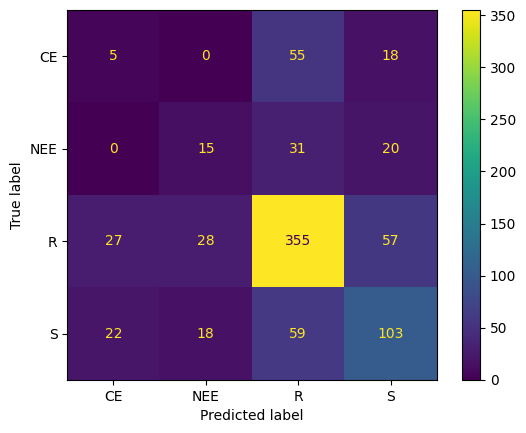

In [ ]:
cmd = ConfusionMatrixDisplay(confusion_matrix(real_test_y, pred_y), display_labels=['CE', 'NEE', 'R', 'S'])
cmd.plot()

In [ ]:
classifier.save('./drive/MyDrive/Colab Notebooks/NLP/models/classifier_test10.keras')

As it is possible to note from the confusion matrix, the baseline model is quite good in detecting refused claims but, in classifying "Contrasting Evidence", "Not Enough Evidence" and "Supported" claims its performance is insufficient. Now, a more complex model is developed to try improving the performances of the classifier.

## BERT for classification
The idea employed in this section tries to replicate the model proposed in the original SBERT paper (https://arxiv.org/abs/1908.10084) for classification purposes. A SBERT model is finetuned being proposed of claim - question and answer pairs being the concatenation of the sentence embeddings produced passed through a softmax classifier:

![Architecture](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SBERT_SoftmaxLoss.png)

The purpose of this model is to finetune sbert to produce the best embeddings to improve the classification task.

More technically, we used the Sentence Transformers library to get the base SBERT model, to which are added a couple dense layers and a pooling layer. Finally, the model is wrapped with the SoftmaxLoss class offered by the library to allow a classification output.

In [ ]:
labels = claims_df['label']
class_names = np.unique(labels)
class_names

array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
       'Refuted', 'Supported'], dtype=object)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
# Transform labels
y_encoded = label_encoder.fit_transform(labels)

In [ ]:
samples_train = []
samples_test = []

for index, claim in claims_df.iterrows():
    answers = answers_df[answers_df["claim_id"]==index]
    if claim['split'] == 'train':
        for _, answer in answers.iterrows():
            samples_train.append(InputExample(texts=[claim["claim"], answer["question"]+" "+answer['answer']], label=y_encoded[index]))
    else:
        for _, answer in answers.iterrows():
            samples_test.append(InputExample(texts=[claim["claim"], answer["question"]+" "+answer['answer']], label=y_encoded[index]))


In [ ]:
# OLD MODEL
model_name = "distilbert-base-nli-mean-tokens"
model_version = "-classifier-2"
train_batch_size = 16
num_epochs = 10
model_save_path = (
    "./drive/MyDrive/Colab Notebooks/NLP/models/" + model_name + model_version
)
model_c = SentenceTransformer(model_name)

In [ ]:
# CUSTOM MODEL WITH POOLING
model_name = "bert-base-uncased"
model_version = "-classifier"
train_batch_size = 16
num_epochs = 4
model_save_path = (
    "./drive/MyDrive/Colab Notebooks/NLP/models/" + model_name + model_version
)
# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = Transformer(model_name)

dense_1 = Dense(in_features = word_embedding_model.get_word_embedding_dimension(), out_features = 128, activation_function = nn.ReLU())
dense_2 = Dense(in_features = 128, out_features = 64, activation_function = nn.ReLU())

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

# model_c = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model_c = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_1, dense_2])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
train_dataloader = DataLoader(samples_train, shuffle=True, batch_size=train_batch_size)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
train_loss = losses.SoftmaxLoss(
    model=model_c,
    sentence_embedding_dimension=model_c.get_sentence_embedding_dimension(),
    num_labels=len(class_names)
)

The entire model is first fitted, then the SBERT component is freezed and only the classification block is further finetuned.

In [ ]:
model_c.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

In [ ]:
model_c

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 128, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
  (3): Dense({'in_features': 128, 'out_features': 64, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
)

In [ ]:
# Freeeze all parameters
for param in model_c.parameters():
    param.requires_grad = False

In [ ]:
model_c[2].requires_grad = True
model_c[3].requires_grad = True

In [ ]:
train_loss_finetuning = losses.SoftmaxLoss(
    model=model_c,
    sentence_embedding_dimension=model_c.get_sentence_embedding_dimension(),
    num_labels=len(class_names)
)

In [ ]:
model_c.fit(
    train_objectives=[(train_dataloader, train_loss_finetuning)],
    epochs=4,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

Iteration:   0%|          | 0/479 [00:00<?, ?it/s]

In [ ]:
# Freeeze all parameters
for param in model_c.parameters():
    param.requires_grad = False

In [ ]:
# define test dataloader
test_dataloader = DataLoader(samples_test, shuffle=True, batch_size=4)

In [ ]:
test_evaluator = LabelAccuracyEvaluator(test_dataloader, name="sts-test", softmax_model=train_loss_finetuning)
test_evaluator(model_c)

0.6063960639606396

### Test model

In [ ]:
model_name = "distilbert-base-nli-mean-tokens"
model_version = "-classifier-2"
model_c = SentenceTransformer("./drive/MyDrive/Colab Notebooks/NLP/models/"+model_name+model_version)

In [ ]:
embedded_claims = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_claims_test10.npy", allow_pickle=True)
embedded_q_a = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_q_a_test10.npy", allow_pickle=True)

In [ ]:
softmax_model = losses.SoftmaxLoss(
    model=model_c,
    sentence_embedding_dimension=model_c.get_sentence_embedding_dimension(),
    num_labels=len(class_names)
)

In [ ]:
def batch_to_device(batch, target_device):
    """
    send a pytorch batch to a device (CPU/GPU)
    """
    for key in batch:
        if isinstance(batch[key], Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

We employed two apporoaches to test both the ranker and the classifier:
- A majority voting approach in which the 3 most similar claim - question and answer pairs are extracted classified separately and a majority voting is applied to extract the final label.
- A one-shot classification made by extrcting the 3 most similar claim  - question and answer performed by concatenating all 3 question-ansers in a single string and then given in input to the classification model.

In [ ]:
## MAJOIRITY VOTING

model_c.eval()
k = 3
final_predictions = []
for index_claim, claim in claims_df[claims_df['split']=='test'].iterrows():
    # Find k most similar answers to this topic
    query_embedding = np.repeat([embedded_claims[index_claim]], len(embedded_q_a), axis=0)
    cosine_distances = paired_cosine_distances(query_embedding, embedded_q_a)
    # Find indexes of most similar embeddings
    most_similar_indexes = np.argsort(cosine_distances)[:k]

    labels = torch.tensor([y_encoded[index_claim]])
    label_ids = labels.to(model_c.device)

    predictions = []
    # Compute k predictions
    for index_answer, answer in answers_df.iloc[most_similar_indexes].iterrows():
        texts = [[claim["claim"], answer["question"]+" "+answer['answer']]]
        sentence_features = [model_c.tokenize(sentence) for sentence in zip(*texts)]
        for idx in range(len(sentence_features)):
            sentence_features[idx] = batch_to_device(sentence_features[idx], model_c.device)
        with torch.no_grad():
            _, prediction = softmax_model(sentence_features, labels=None)
        prediction = torch.argmax(prediction, dim=1)
        predictions.append(prediction.item())

    majority_vote = max(set(predictions), key=predictions.count)
    final_predictions.append(majority_vote)


In [ ]:
print('accuracy: '+ str(accuracy_score(y_encoded[claims_df['split']=='test'], final_predictions)))
print('precision: '+ str(precision_score(y_encoded[claims_df['split']=='test'], final_predictions, average='weighted')))

accuracy: 0.43506493506493504
precision: 0.46898190833282116


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


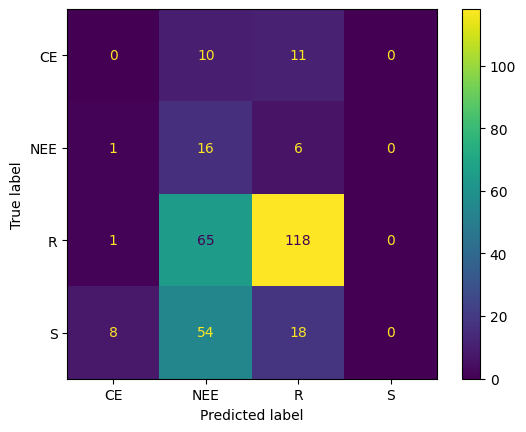

In [ ]:
cmd = ConfusionMatrixDisplay(confusion_matrix(y_encoded[claims_df['split']=='test'], final_predictions), display_labels=['CE', 'NEE', 'R', 'S'])
cmd.plot()

In [ ]:
## QUESTION + ANSWERS CONCATENATION IN A SINGLE STRING
model_c.eval()
k = 3
final_predictions = []
for index_claim, claim in claims_df[claims_df['split']=='test'].iterrows():
    # Find k most similar answers to this topic
    query_embedding = np.repeat([embedded_claims[index_claim]], len(embedded_q_a), axis=0)
    cosine_distances = paired_cosine_distances(query_embedding, embedded_q_a)
    # Find indexes of most similar embeddings
    most_similar_indexes = np.argsort(cosine_distances)[:k]

    labels = torch.tensor([y_encoded[index_claim]])
    label_ids = labels.to(model_c.device)

    question = ""
    # Compute k prediction
    for index_answer, answer in answers_df.iloc[most_similar_indexes].iterrows():
        question += answer["question"]+ " " + answer['answer'] + " "

    # texts = [["[CLAIM] " + claim["claim"], "[QUESTION] " + question]]
    texts = [[claim["claim"], question]]
    sentence_features = [model_c.tokenize(sentence) for sentence in zip(*texts)]

    for idx in range(len(sentence_features)):
        sentence_features[idx] = batch_to_device(sentence_features[idx], model_c.device)
    with torch.no_grad():
        _, prediction = softmax_model(sentence_features, labels=None)
    prediction = torch.argmax(prediction, dim=1)
    final_predictions.append(prediction.item())

In [ ]:
print('accuracy: '+ str(accuracy_score(y_encoded[claims_df['split']=='test'], final_predictions)))
print('precision: '+ str(precision_score(y_encoded[claims_df['split']=='test'], final_predictions, average='weighted')))

accuracy: 0.44155844155844154
precision: 0.4649720532631925


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


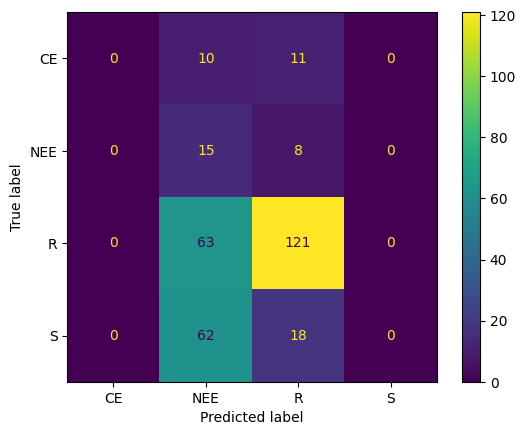

In [ ]:
cmd = ConfusionMatrixDisplay(confusion_matrix(y_encoded[claims_df['split']=='test'], final_predictions), display_labels=['CE', 'NEE', 'R', 'S'])
cmd.plot()

As it is possible to note from both the confusion matrixes of the majority voting and the concatenation approaches, the performances are very poor, being the behaviour of the model almost random.

## Custom classifier

We define a custom neural network model. It integrates a Sentence Transformer to embed the input text and a series of fully connected layers to perform the final classification.
The input to the model is a concatenated string in the following format: "[CLAIM] Text of claim [QUESTION] Question? Answer concatenated".

NB. In our previous attempts to classify claim-answer pairs using the defined models, we observed significant difficulties in accurately classifying the following minority labels: Conflicting Evidence/Cherrypicking, Not Enough Evidence.
These minority classes have fewer examples compared to more common classes like 'Refuted' or 'Supported'. This imbalance causes the model to be biased towards the majority classes, often neglecting the minority ones. We decided to discard these categories from our classification task. This decision was made to simplify the problem and improve the overall classification performance for the remaining classes.

In [ ]:
# Merge claims to all their associated answers
train_df = pd.merge(claims_df[claims_df['split'] == 'train'], answers_df, on='claim_id')[['claim', 'answer', 'label', 'question']]
# Discard all other labels except 'Refuted' and 'Supported'
train_df = train_df[train_df['label'].isin(['Refuted', 'Supported'])]
# Encode labels
train_df['label'] = train_df['label'].map({'Refuted': 0, 'Supported': 1})
# Concatenate claim, question, answer
train_df['text'] = '[CLAIM] ' + train_df['claim'] + ' [QUESTION] ' + train_df['question'] + ' ' + train_df['answer']

test_df = pd.merge(claims_df[claims_df['split'] == 'test'], answers_df, on='claim_id')[['claim', 'answer', 'label', 'question']]
test_df = test_df[test_df['label'].isin(['Refuted', 'Supported'])]
test_df['label'] = test_df['label'].map({'Refuted': 0, 'Supported': 1})
test_df['text'] = '[CLAIM] ' + test_df['claim'] + ' [QUESTION] ' + test_df['question'] + ' ' + test_df['answer']

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, embedder_model_name, num_classes):
        super(CombinedModel, self).__init__()
        self.embedder = SentenceTransformer(embedder_model_name)
        input_dim = self.embedder.get_sentence_embedding_dimension()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, texts, device):
        # The concatenated input text is first encoded using the Sentence Transformer to generate embeddings.
        embeddings = self.embedder.encode(texts, convert_to_tensor=True).to(device)
        # These embeddings are then passed through the series of fully connected layers with ReLU activations.
        x = self.fc1(embeddings)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # The final layer applies softmax activation to output class probabilities.
        return self.softmax(x)

In [ ]:
class ClaimAnswerDataset(Dataset):
    def __init__(self, qa, labels):
        self.texts = qa
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
dataset = ClaimAnswerDataset(train_df['text'].tolist(), train_df['label'].tolist())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

### Train model

all-MiniLM-L6-v2 is a pre-trained language model part of the Sentence Transformers library. It is specifically designed to provide efficient and high-quality sentence embeddings for various natural language processing tasks. It has only 6 transformer layers, making it lightweight and fast compared to larger models like BERT or RoBERTa.

In [ ]:
# Define the model
model_name = 'all-MiniLM-L6-v2'
num_classes = 2  # Number of classes
model = CombinedModel(model_name, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for texts, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(texts, device)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(labels)

    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the model
torch.save(model.state_dict(),'./drive/MyDrive/Colab Notebooks/NLP/models/custom_model_2.pth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 1/5: 100%|██████████| 386/386 [00:12<00:00, 31.01batch/s]


Epoch [1/5], Loss: 0.5582


Epoch 2/5: 100%|██████████| 386/386 [00:14<00:00, 26.06batch/s]


Epoch [2/5], Loss: 0.4907


Epoch 3/5: 100%|██████████| 386/386 [00:16<00:00, 22.76batch/s]


Epoch [3/5], Loss: 0.4486


Epoch 4/5: 100%|██████████| 386/386 [00:13<00:00, 28.42batch/s]


Epoch [4/5], Loss: 0.4234


Epoch 5/5: 100%|██████████| 386/386 [00:12<00:00, 31.01batch/s]


Epoch [5/5], Loss: 0.4059


### Test model

In [ ]:
# Load the model
model = CombinedModel(model_name, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/NLP/models/custom_model_2.pth', map_location=torch.device(device)))
model.to(device)

CombinedModel(
  (embedder): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Normalize()
  )
  (fc): Linear(in_features=384, out_features=4, bias=True)
)

In [ ]:
model.eval()

predictions = []
for idx_claim, claim in test_df.iterrows():
    with torch.no_grad():
        output = model([claim['text']], device)
        _, predicted_label = torch.max(output, dim=1)
    predictions.append(predicted_label.item())

In [ ]:
print('accuracy: '+ str(accuracy_score(test_df['label'], predictions)))

accuracy: 0.7328467153284671


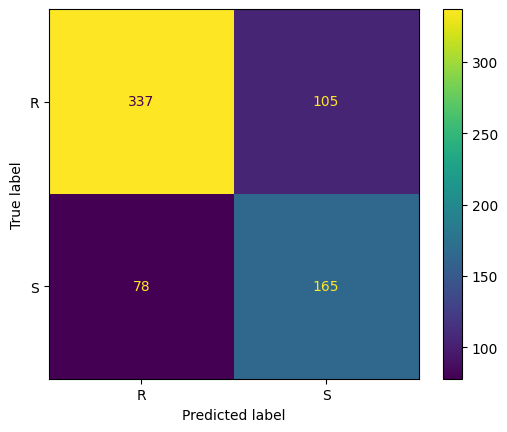

In [ ]:
cmd = ConfusionMatrixDisplay(confusion_matrix(test_df['label'], predictions), display_labels=[ 'R', 'S'])
cmd.plot()

## Final ensemble

In [ ]:
# Load the embeddings
embedded_claims = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_claims_test10.npy", allow_pickle=True)
embedded_q_a = np.load("./drive/MyDrive/Colab Notebooks/NLP/encoded_q_a_test10.npy", allow_pickle=True)

In [ ]:
# Load the classifier
model_name = 'all-MiniLM-L6-v2'
num_classes = 2
custom_classifier = CombinedModel(model_name, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_classifier.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/NLP/models/custom_model_2.pth', map_location=torch.device(device)))
custom_classifier.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CombinedModel(
  (embedder): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Normalize()
  )
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In our dataset, each claim typically has an average of 3 corresponding answers. This observation guided our approach to handling multiple answers during the classification task.

To ensure robustness and reliability in our classification system, we employ a majority voting mechanism to determine the final predictions for each claim.

In [ ]:
custom_classifier.eval()
k = 3
final_predictions = []

test_claims = claims_df[(claims_df['split'] == 'test') & (claims_df['label'].isin(['Refuted', 'Supported']))].copy()
test_claims['label'] = test_claims['label'].map({'Refuted': 0, 'Supported': 1})

for idx_claim, claim in tqdm(test_claims.iterrows(), total=test_claims.shape[0], desc="Processing claims"):
    # Find k most similar answers to this topic
    query_embedding = np.repeat([embedded_claims[idx_claim]], len(embedded_q_a), axis=0)
    cosine_distances = paired_cosine_distances(query_embedding, embedded_q_a)
    # Find indexes of most similar embeddings
    most_similar_indexes = np.argsort(cosine_distances)[:k]

    predictions = []
    # Compute k predictions
    for idx_answer, answer in answers_df.iloc[most_similar_indexes].iterrows():
        text = '[CLAIM] ' + claim['claim'] + ' [QUESTION] ' + answer['question'] + ' ' + answer['answer']
        with torch.no_grad():
            output = custom_classifier([text], device)
            _, predicted_label = torch.max(output, dim=1)
        predictions.append(predicted_label.item())

    # Majority voting
    majority_vote = max(set(predictions), key=predictions.count)
    final_predictions.append(majority_vote)

Processing claims: 100%|██████████| 264/264 [01:21<00:00,  3.22it/s]


In [ ]:
print('accuracy: '+ str(accuracy_score(test_claims['label'], final_predictions)))

accuracy: 0.8371212121212122


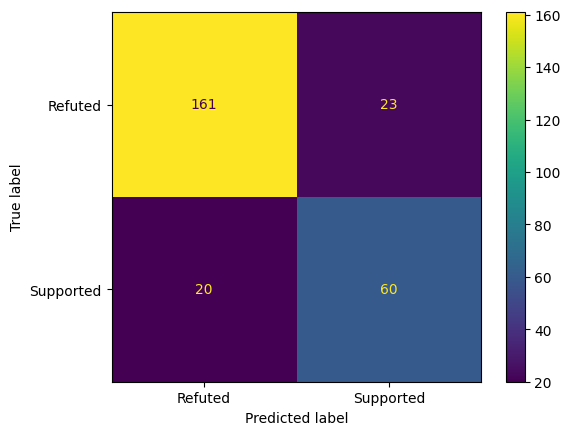

In [ ]:
cmd = ConfusionMatrixDisplay(confusion_matrix(test_claims['label'], final_predictions), display_labels=[ 'Refuted', 'Supported'])
cmd.plot()

The confusion matrix shows nice performances in discriminating both refuted and supported samples.

# Speech recognition

This cell converts file audio from .unknown format to .wav. It's necessary for the speech recognition library to work properly. The .unknown format is just an unfortunate format that followed from the registration of our voices using our phone. Anyway the process can starts from other audio format

In [ ]:
!ffmpeg -i /content/drive/MyDrive/Colab\ Notebooks/NLP/File_Audio/claim1.unknown claim1.wav
!ffmpeg -i /content/drive/MyDrive/Colab\ Notebooks/NLP/File_Audio/claim2.unknown claim2.wav
!ffmpeg -i /content/drive/MyDrive/Colab\ Notebooks/NLP/File_Audio/claim3.unknown claim3.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

The three file names get inserted in a list and then the speech recognition is performed one file at a time using the SpeechRecognition library. Some exceptions are checked in order to ensure proper working of the library.

In [ ]:
claims = ["claim"+str(i)+".wav" for i in range(1,4)]
true_claims = ["The Kenyan judiciary does not even get 1% of the national budget",
               "Donald Trump delivered the largest tax cuts in American history",
               "Biden has pledged to stop border wall construction and give amnesty and health care to all illegal immigrants"]

for claim,true_claim in zip(claims,true_claims):
  # Initialize the speech recognition object
  recognizer = sr.Recognizer()

  # Read the file audio
  with sr.AudioFile(claim) as source:
      audio_data = recognizer.record(source)

  # Convert the file audio in a string and prints it next to the original text
  try:
      text = recognizer.recognize_google(audio_data, language='en-EN')
      print("Recognised text:", text)
      print("Original Text:", true_claim)
      print()
  except sr.UnknownValueError:
      print("Impossible to recognised the text.")
  except sr.RequestError as e:
      print("Error in the request:", e)

Testo riconosciuto: the Kenyan Judiciary does not even get 1% of the national budget
Testo originale: The Kenyan judiciary does not even get 1% of the national budget

Testo riconosciuto: Donald Trump delivered the largest tax cuts in American history
Testo originale: Donald Trump delivered the largest tax cuts in American history

Testo riconosciuto: Biden has pledged to stop border wall construction and give amnesty and Healthcare to all illegal immigrants
Testo originale: Biden has pledged to stop border wall construction and give amnesty and health care to all illegal immigrants



# Justification generator

The purpose of the justification generator is to generate a justification to explain why a certain claim has been classified in a certain manner.

To generate such an explanation we retrieve the three most similar question-answer pairs in the dataset with the sentence-BERT model we trained, and then we use a t5 model to summarize the content of the answers toghether with the claim and it's veracity.

###Load Models

####Sbert

In [ ]:
#sbert
semb_model = SentenceTransformer("./models/nli-distilroberta-base-v2-claim-question-answer")

####Generative Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="cuda", torch_dtype=torch.bfloat16)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###Try the model

In [ ]:
#Select a random claim
idx = random.choice(range(len(claims_df)))

claim = claims_df.iloc[idx]['claim']
label = claims_df.iloc[idx]['label']

#Embed the claim
claim_embedding = np.repeat([semb_model.encode(claim, convert_to_numpy=True)], len(encoded_q_a), axis=0)
# Calculate paired cosine distances
cosine_distances = paired_cosine_distances(claim_embedding, encoded_q_a)
# Find indexes of most similar embeddings
most_similar_indexes = np.argsort(cosine_distances)
# Get best matching pairs
answers = []
for i in most_similar_indexes[:3]:
  answers.append(answers_df.iloc[i]['answer'])

#Generate model input
input_text = f"Summarize:\n{claim}\n"
input_text +="".join([f"{answers[i]}\n" for i,j in enumerate(answers)])
input_text +=f"{label}"

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"A (output): {output_text} \n")

# Final Pipeline

Our final pipeline is organized as follows:


*   Use SBERT to find the most similar question-answer pairs with respect to the claim in terms of cosine distance
*   Collect the corresponding pairs from the dataset and use t5 to summarize the answers which lenght is greater than 40 words.
*   Use the classifier model to predict the veracity of the claim
*   Use t5 again to summarize the content of the claim, the retrieved answers and the predicted veracity in a new sentence

We decided to summarize answers longer than 40 words because we observed that answers which are too much longer with respect to the others will become the greater portion of the final summarizer input, making the other content useless to the computation of the justification


In [ ]:
def qa_pipeline(
    claim,
    similarity_model=semb_model,
    generative_model=model,
    custom_classifier=custom_classifier,
    device=device,
):
    # Embed claim
    claim_embedding = np.repeat([semb_model.encode(claim, convert_to_numpy=True)], len(embedded_q_a), axis=0)
    # Calculate paired cosine distances
    cosine_distances = paired_cosine_distances(claim_embedding, embedded_q_a)
    # Find indexes of most similar embeddings
    most_similar_indexes = np.argsort(cosine_distances)
    # Get best matching passages
    summarized_answers = []
    questions = []
    answers = []
    for i in most_similar_indexes[:3]:
      question = answers_df.iloc[i]['question']
      answer = answers_df.iloc[i]['answer']
      questions.append(question)
      answers.append(answer)
      if len(answer.split(" ")) > 40:
        input_text = f"Summarize: {answer}"
        print("a")
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
        # Generate output
        output_ids = model.generate(input_ids, max_new_tokens=128)
        # Decode output
        answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
      summarized_answers.append(answer)

    # Veracity prediction
    predictions = []
    # Compute k predictions
    for i in range(len(questions)):
        text = '[CLAIM] ' + claim + ' [QUESTION] ' + questions[i] + ' ' + answers[i]
        with torch.no_grad():
            output = custom_classifier([text], device)
            _, predicted_label = torch.max(output, dim=1)
        predictions.append(predicted_label.item())

    # Majority voting
    majority_voting = max(set(predictions), key=predictions.count)

    if (majority_voting == 0):
      veracity="Refuted"
    else:
      veracity="Supported"


    # Encode input
    input_text = f"Summarize:\n{claim}\n"
    input_text +="".join([f"{answers[i]}\n" for i,j in enumerate(answers)])
    input_text +=f"{veracity}"

    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = model.generate(input_ids, max_new_tokens=64)
    # Decode output
    justification = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    output_text = f"Predicted veracity: {veracity}\n\nJustification: " + justification
    # Return result
    return f"{output_text}"

Let's try it out:

In [ ]:
claim = input("State a claim >>> ")
out = qa_pipeline(claim)
print("\n\n")
print(out)

State a claim >>> In Nigeria,99% of revenue is being committed to debt servicing alone.



Predicted veracity: Supported

Justification: Nigeria's debt is estimated at Ksh904.7 billion.
